<a href="https://colab.research.google.com/github/JannaBabicheva/Tour-region-econometrics/blob/main/%D0%91%D0%B0%D0%B1%D0%B8%D1%87%D0%B5%D0%B2%D0%B0_%D0%96_%D0%9A___%D1%82%D1%83%D1%80%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%B8%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка библиотек

In [ ]:
# Установка библиотек
!pip install pulp
!pip install statsmodels
!pip install scikit-learn
!pip install pandas numpy matplotlib
!pip install pysal
!pip install linearmodels
!pip install spreg
# Установка библиотек
!pip install pandas numpy matplotlib seaborn scipy statsmodels linearmodels libpysal spreg esda

In [ ]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

import pandas as pd
import numpy as np
from scipy.stats import yeojohnson
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from libpysal.weights import KNN
from spreg import GM_Lag
from esda.moran import Moran
import logging
from scipy import stats
from scipy.stats import norm, linregress
from linearmodels.panel import RandomEffects, PooledOLS
from linearmodels.panel import compare
from linearmodels.iv import IVGMM
from spreg import GM_Lag, GM_Error
import libpysal
from esda.moran import Moran
from scipy.stats import shapiro, boxcox
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import yeojohnson
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from spreg import GM_Lag
import libpysal.weights as weights
import geopandas as gpd
from pysal.model import spreg
from pysal.explore import esda
import uuid

# Подключение к диску

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Первый вариант

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from libpysal.weights import W
from pysal.model import spreg
from pysal.explore import esda
import uuid

In [ ]:
# Теоретическая модель и гипотезы
print("""
Теоретическая модель:
Спрос на туризм зависит от экономических факторов (ВРП, безработица, население),
инфраструктуры (аэропорты), туристической привлекательности (достопримечательности)
и внешних шоков (кризисы 2009, 2014, COVID-19, санкции).

Гипотезы:
H1: Высокий ВРП на душу населения увеличивает число ночевок.
H2: Высокие цены на проживание снижают число ночевок.
H3: Большее число аэропортов увеличивает число ночевок.
H4: Большее число достопримечательностей увеличивает число ночевок.
H5: Большая численность населения увеличивает число ночевок.
H6: Высокий уровень безработицы снижает число ночевок.
H7: Кризисы 2009, 2014, COVID-19 и санкции снижают число ночевок.
""")

# Функция преобразования в длинный формат
def melt_dataframe(df, id_vars, value_name):
    melt_cols = [col for col in df.columns if col not in id_vars]
    if not melt_cols:
        print(f"Нет колонок для плавления в датафрейме для {value_name}. Пропускаем.")
        return df
    melted_df = pd.melt(df, id_vars=id_vars, value_vars=melt_cols, var_name='year', value_name=value_name)
    melted_df['year'] = pd.to_numeric(melted_df['year'], errors='coerce')
    return melted_df

# Загрузка данных
file_paths = "/content/drive/MyDrive/НИР МФТИ+РАНХиГС/"
hotels = pd.read_excel(file_paths + "2/Число коллективных средств размещения.xlsx")
nights = pd.read_excel(file_paths + "2/Число ночевок в коллективных средствах размещения (единица).xlsx")
prices = pd.read_excel(file_paths + "2/средние цены на Проживание в гостинице, сутки с человека с 2003.xlsx")
salary = pd.read_excel(file_paths + "3/salary_data_2003_2023.xlsx")
gdp = pd.read_excel(file_paths + "3/ВРП на душу населения.xlsx")
investments = pd.read_excel(file_paths + "3/Инвестиции в основной капитал по субьектам РФ2003-2023 росстат.xlsx")
rooms = pd.read_excel(file_paths + "3/rooms.xlsx")
airports_data = pd.read_excel(file_paths + "2/кол-во аэропортов по регионам.xlsx")
attractions = pd.read_excel(file_paths + "2/общее количество достопримечательностей по сбъектам.xlsx")
population = pd.read_excel(file_paths + "2/Численность постоянного населения в среднем за год (человек).xls")
unemployment = pd.read_excel(file_paths + "2/уровень безработицы.xlsx")
adjacency_matrix = pd.read_excel(file_paths + "2/adjacency_matrix.xlsx")


Теоретическая модель:
Спрос на туризм зависит от экономических факторов (ВРП, безработица, население),
инфраструктуры (аэропорты), туристической привлекательности (достопримечательности)
и внешних шоков (кризисы 2009, 2014, COVID-19, санкции).

Гипотезы:
H1: Высокий ВРП на душу населения увеличивает число ночевок.
H2: Высокие цены на проживание снижают число ночевок.
H3: Большее число аэропортов увеличивает число ночевок.
H4: Большее число достопримечательностей увеличивает число ночевок.
H5: Большая численность населения увеличивает число ночевок.
H6: Высокий уровень безработицы снижает число ночевок.
H7: Кризисы 2009, 2014, COVID-19 и санкции снижают число ночевок.



In [ ]:
# Преобразование в длинный формат
hotels_long = melt_dataframe(hotels, ['region'], 'hotels_count')
nights_long = melt_dataframe(nights, ['region'], 'nights_count')
prices_long = melt_dataframe(prices, ['region'], 'price')
salary_long = melt_dataframe(salary, ['region'], 'salary')
gdp_long = melt_dataframe(gdp, ['region'], 'gdp_per_capita')
investments_long = melt_dataframe(investments, ['region'], 'investments')
rooms_long = melt_dataframe(rooms, ['region'], 'rooms_count')
airports_long = melt_dataframe(airports_data, ['region'], 'airports_count')
population_long = melt_dataframe(population, ['region'], 'population')
unemployment_long = melt_dataframe(unemployment, ['region'], 'unemployment')

# Объединение данных
data = hotels_long
data = pd.merge(data, nights_long, on=['region', 'year'], how='left')
data = pd.merge(data, prices_long, on=['region', 'year'], how='left')
data = pd.merge(data, salary_long, on=['region', 'year'], how='left')
data = pd.merge(data, gdp_long, on=['region', 'year'], how='left')
data = pd.merge(data, investments_long, on=['region', 'year'], how='left')
data = pd.merge(data, rooms_long, on=['region', 'year'], how='left')
data = pd.merge(data, airports_long, on=['region', 'year'], how='left')
data = pd.merge(data, population_long, on=['region', 'year'], how='left')
data = pd.merge(data, unemployment_long, on=['region', 'year'], how='left')
data = pd.merge(data, attractions[['region', 'attractions']], on='region', how='left')

# Временные метки
data['crisis_2009'] = (data['year'] == 2009).astype(int)
data['crisis_2014'] = (data['year'] == 2014).astype(int)
data['covid_period'] = ((data['year'] >= 2020) & (data['year'] <= 2022)).astype(int)
data['sanctions_period'] = (data['year'] >= 2022).astype(int)

# Преобразование nights_count
data['nights_count'] = data['nights_count'].astype(str).str.replace(' ', '', regex=False)
data['nights_count'] = pd.to_numeric(data['nights_count'], errors='coerce')

In [ ]:
# Заполнение пропусков медианными значениями
numeric_columns = ['attractions', 'nights_count', 'price', 'salary', 'gdp_per_capita',
                   'investments', 'hotels_count', 'rooms_count', 'airports_count',
                   'population', 'unemployment']
for col in numeric_columns:
    data[col] = data[col].fillna(data[col].median())

# Логарифмирование переменных
vars_to_log = ['nights_count', 'price', 'salary', 'gdp_per_capita', 'investments',
               'hotels_count', 'rooms_count', 'attractions', 'population', 'unemployment']
for var in vars_to_log:
    data[f'ln_{var}'] = np.log(data[var] + 1)
data['ln_airports_count'] = np.log(data['airports_count'] + 1)

In [ ]:
# Синхронизация названий регионов
region_mapping = {
    'Москва': 'Город Москва столица Российской Федерации город федерального значения',
    'Краснодарский край': 'Краснодарский край',
    'Санкт-Петербург': 'Город Санкт-Петербург город федерального значения',
    'Ингушетия': 'Республика Ингушетия',
    'Чукотский АО': 'Чукотский автономный округ',
    'Московская область': 'Московская область'
}
data['region'] = data['region'].replace(region_mapping)
print("Названия регионов синхронизированы с adjacency_matrix.")

Названия регионов синхронизированы с adjacency_matrix.


In [ ]:
# Установка мультииндекса
data = data.set_index(['region', 'year'])

In [ ]:
# Описание зависимой переменной (лидеры и аутсайдеры)
data_2023 = data.xs(2023, level='year').reset_index()
top_5 = data_2023[['region', 'nights_count']].sort_values('nights_count', ascending=False).head(5)
bottom_5 = data_2023[['region', 'nights_count']].sort_values('nights_count').head(5)
leaders_outsiders = pd.concat([top_5, bottom_5])
print("\nЛидеры и аутсайдеры по числу ночевок (2023):")
print(leaders_outsiders)
leaders_outsiders.to_excel(file_paths + "leaders_outsiders.xlsx", index=False)


Лидеры и аутсайдеры по числу ночевок (2023):
                                               region  nights_count
17  Город Москва столица Российской Федерации горо...      62186273
30                                 Краснодарский край      56785168
9                                  Московская область      26672469
27  Город Санкт-Петербург город федерального значения      25214478
40                                Ставропольский край      10741134
79                         Чукотский автономный округ         44870
35                               Республика Ингушетия         59685
29                                Республика Калмыкия        161215
78                       Еврейская автономная область        181738
60                                    Республика Тыва        248876


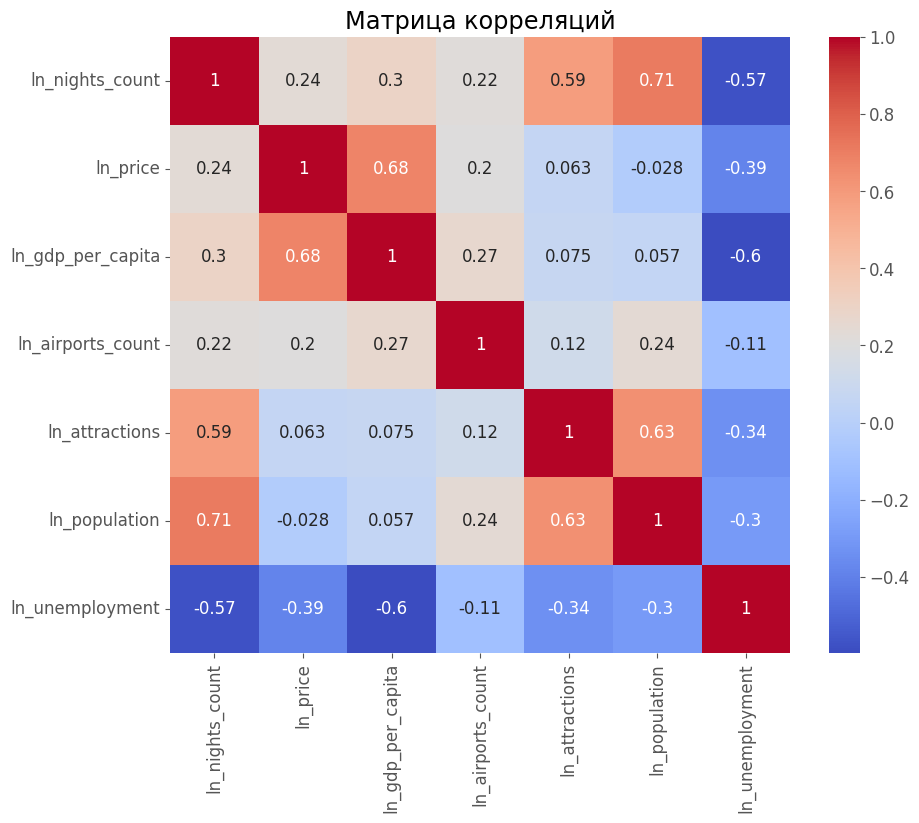


Матрица корреляций:
                   ln_nights_count  ln_price  ln_gdp_per_capita  \
ln_nights_count           1.000000  0.235187           0.296127   
ln_price                  0.235187  1.000000           0.676077   
ln_gdp_per_capita         0.296127  0.676077           1.000000   
ln_airports_count         0.219873  0.201291           0.269689   
ln_attractions            0.585985  0.062738           0.075191   
ln_population             0.710300 -0.027767           0.056589   
ln_unemployment          -0.574989 -0.389939          -0.597420   

                   ln_airports_count  ln_attractions  ln_population  \
ln_nights_count             0.219873        0.585985       0.710300   
ln_price                    0.201291        0.062738      -0.027767   
ln_gdp_per_capita           0.269689        0.075191       0.056589   
ln_airports_count           1.000000        0.120947       0.243564   
ln_attractions              0.120947        1.000000       0.632569   
ln_population   

In [ ]:
# Матрица корреляций
corr_vars = ['ln_nights_count', 'ln_price', 'ln_gdp_per_capita', 'ln_airports_count',
             'ln_attractions', 'ln_population', 'ln_unemployment']
corr_matrix = data[corr_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.savefig(file_paths + "corr_matrix.png")
plt.show()
print("\nМатрица корреляций:")
print(corr_matrix)

In [ ]:
# Определение переменных
dependent = data['ln_nights_count']
exog_vars_base = ['ln_gdp_per_capita']
exog_vars_extended = ['ln_price', 'ln_gdp_per_capita', 'ln_airports_count',
                      'ln_attractions', 'ln_population', 'ln_unemployment']
exog_vars_full = exog_vars_extended + ['crisis_2009', 'crisis_2014', 'covid_period', 'sanctions_period']
exog_vars_gmm = ['ln_gdp_per_capita', 'ln_population', 'ln_unemployment']

In [ ]:
# Переименование переменных для интерпретации
var_names = {
    'ln_nights_count': 'Логарифм числа ночевок (туризм)',
    'ln_price': 'Логарифм цены проживания',
    'ln_gdp_per_capita': 'Логарифм ВРП на душу населения',
    'ln_airports_count': 'Логарифм числа аэропортов (инфраструктура)',
    'ln_attractions': 'Логарифм числа достопримечательностей (туризм)',
    'ln_population': 'Логарифм численности населения',
    'ln_unemployment': 'Логарифм уровня безработицы',
    'crisis_2009': 'Кризис 2009',
    'crisis_2014': 'Кризис 2014',
    'covid_period': 'Период COVID-19',
    'sanctions_period': 'Период санкций'
}

In [ ]:
# Проверка пропусков
print("\nПропуски в данных перед обучением моделей:")
print(data[exog_vars_full + ['ln_nights_count']].isna().sum())


Пропуски в данных перед обучением моделей:
ln_price             0
ln_gdp_per_capita    0
ln_airports_count    0
ln_attractions       0
ln_population        0
ln_unemployment      0
crisis_2009          0
crisis_2014          0
covid_period         0
sanctions_period     0
ln_nights_count      0
dtype: int64


In [ ]:
# Проверка VIF
def calculate_vif(exog):
    X_vif = sm.add_constant(exog)
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X_vif.columns
    vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    return vif_data

print("\nVIF для переменных (exog_full):")
print(calculate_vif(data[exog_vars_full]))


VIF для переменных (exog_full):
             Variable          VIF
0               const  1020.833386
1            ln_price     1.920848
2   ln_gdp_per_capita     3.134743
3   ln_airports_count     1.198556
4      ln_attractions     1.781029
5       ln_population     1.838224
6     ln_unemployment     1.977226
7         crisis_2009     1.039154
8         crisis_2014     1.031535
9        covid_period     1.298371
10   sanctions_period     1.268416


## Модели (только линейные)

In [ ]:
# 1. Базовая Pooled OLS
base_model = PooledOLS(dependent, sm.add_constant(data[exog_vars_base]))
base_results = base_model.fit(cov_type='robust')
print("\nРезультаты базовой Pooled OLS:")
print(base_results.summary)


Результаты базовой Pooled OLS:
                          PooledOLS Estimation Summary                          
Dep. Variable:        ln_nights_count   R-squared:                        0.0877
Estimator:                  PooledOLS   R-squared (Between):              0.1023
No. Observations:                1680   R-squared (Within):               0.0073
Date:                Mon, May 19 2025   R-squared (Overall):              0.0877
Time:                        17:02:24   Log-likelihood                   -2896.8
Cov. Estimator:                Robust                                           
                                        F-statistic:                      161.29
Entities:                          80   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                  F(1,1678)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):             58.

In [ ]:
# 2. Расширенная Pooled OLS
extended_model = PooledOLS(dependent, sm.add_constant(data[exog_vars_extended]))
extended_results = extended_model.fit(cov_type='robust')
print("\nРезультаты расширенной Pooled OLS:")
print(extended_results.summary)


Результаты расширенной Pooled OLS:
                          PooledOLS Estimation Summary                          
Dep. Variable:        ln_nights_count   R-squared:                        0.6717
Estimator:                  PooledOLS   R-squared (Between):              0.7579
No. Observations:                1680   R-squared (Within):               0.1958
Date:                Mon, May 19 2025   R-squared (Overall):              0.6717
Time:                        17:02:41   Log-likelihood                   -2038.2
Cov. Estimator:                Robust                                           
                                        F-statistic:                      570.55
Entities:                          80   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                  F(6,1673)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):            

In [ ]:
# 3. OLS с фиксированными эффектами регионов
fe_region_model = PanelOLS(dependent, data[exog_vars_full], entity_effects=True, drop_absorbed=True)
fe_region_results = fe_region_model.fit(cov_type='robust')
print("\nРезультаты OLS с фиксированными эффектами (регионы):")
print(fe_region_results.summary)

<ipython-input-46-f232009889fd>:3: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

ln_attractions

  fe_region_results = fe_region_model.fit(cov_type='robust')



Результаты OLS с фиксированными эффектами (регионы):
                          PanelOLS Estimation Summary                           
Dep. Variable:        ln_nights_count   R-squared:                        0.3554
Estimator:                   PanelOLS   R-squared (Between):             -13.350
No. Observations:                1680   R-squared (Within):               0.3554
Date:                Mon, May 19 2025   R-squared (Overall):             -13.328
Time:                        17:02:52   Log-likelihood                   -1030.1
Cov. Estimator:                Robust                                           
                                        F-statistic:                      97.479
Entities:                          80   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                  F(9,1591)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (ro

In [ ]:
# 4. OLS с фиксированными эффектами времени
fe_time_model = PanelOLS(dependent, data[exog_vars_extended], time_effects=True)
fe_time_results = fe_time_model.fit(cov_type='robust')
print("\nРезультаты OLS с фиксированными эффектами (время):")
print(fe_time_results.summary)


Результаты OLS с фиксированными эффектами (время):
                          PanelOLS Estimation Summary                           
Dep. Variable:        ln_nights_count   R-squared:                        0.6770
Estimator:                   PanelOLS   R-squared (Between):              0.9830
No. Observations:                1680   R-squared (Within):               0.0468
Date:                Mon, May 19 2025   R-squared (Overall):              0.9816
Time:                        17:03:03   Log-likelihood                   -2008.0
Cov. Estimator:                Robust                                           
                                        F-statistic:                      577.36
Entities:                          80   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                  F(6,1653)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robu

In [ ]:
# 5. Модель со случайными эффектами
re_model = RandomEffects(dependent, data[exog_vars_full])
re_results = re_model.fit(cov_type='robust')
print("\nРезультаты модели со случайными эффектами:")
print(re_results.summary)


Результаты модели со случайными эффектами:
                        RandomEffects Estimation Summary                        
Dep. Variable:        ln_nights_count   R-squared:                        0.9481
Estimator:              RandomEffects   R-squared (Between):              0.9972
No. Observations:                1680   R-squared (Within):               0.2691
Date:                Mon, May 19 2025   R-squared (Overall):              0.9961
Time:                        17:03:13   Log-likelihood                   -1178.4
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3050.7
Entities:                          80   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                 F(10,1670)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):    

In [ ]:
# Диагностика (только для FE Regions, как основной модели)
# Остатки для FE Regions
y_pred_region = fe_region_results.predict()
if isinstance(y_pred_region, pd.DataFrame):
    y_pred_region = y_pred_region.iloc[:, 0]
original_index = dependent.index
y_pred_region = y_pred_region.reindex(original_index)
y_pred_region_full = pd.Series(np.nan, index=original_index)
y_pred_region_full = y_pred_region_full.combine_first(y_pred_region)
y_pred_region_full = y_pred_region_full.fillna(y_pred_region.mean())
residuals_region = dependent - y_pred_region_full
residuals_region_2023 = residuals_region[residuals_region.index.get_level_values('year') == 2023]
residuals_region_filtered = residuals_region_2023[residuals_region_2023.index.get_level_values('region').isin(available_columns)]

# Тест Бройша-Пагана на гетероскедастичность
bp_test = het_breuschpagan(residuals_region_filtered, sm.add_constant(data[exog_vars_full].loc[residuals_region_filtered.index]))
print("\nBreusch-Pagan test for heteroskedasticity (Fixed Effects Regions):")
print(f"LM Statistic: {bp_test[0]}, p-value: {bp_test[1]}")

# Тест Шапиро-Уилка на нормальность
shapiro_test = stats.shapiro(residuals_region_filtered)
print("\nShapiro-Wilk test for normality (Fixed Effects Regions):")
print(f"Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")


Breusch-Pagan test for heteroskedasticity (Fixed Effects Regions):
LM Statistic: 75.3220041492734, p-value: 1.3650508847940632e-12

Shapiro-Wilk test for normality (Fixed Effects Regions):
Statistic: 0.9578205202252065, p-value: 0.012042361632931632


In [ ]:
# Тест Хаусмана (FE Regions vs RE)
def hausman_test(fe_results, re_results):
    try:
        fe_params = fe_results.params
        re_params = re_results.params
        common_params = fe_params.index.intersection(re_params.index)
        diff = fe_params[common_params] - re_params[common_params]
        var_diff = fe_results.cov.loc[common_params, common_params] - re_results.cov.loc[common_params, common_params]
        chi2_stat = diff.T @ np.linalg.inv(var_diff) @ diff
        df = len(common_params)
        p_value = 1 - stats.chi2.cdf(chi2_stat, df)
        return chi2_stat, p_value
    except Exception as e:
        print(f"Ошибка в тесте Хаусмана: {e}")
        return None, None

chi2_stat, p_value = hausman_test(fe_region_results, re_results)
if chi2_stat is not None:
    print("\nТест Хаусмана (регионы vs случайные эффекты):")
    print(f"Chi² Statistic: {chi2_stat}, p-value: {p_value}")
    if p_value < 0.05:
        print("p-value < 0.05: Используем фиксированные эффекты регионов.")
    else:
        print("p-value >= 0.05: Можно использовать случайные эффекты.")
else:
    print("Тест Хаусмана не выполнен из-за ошибки.")

# VIF без константы (ваш фрагмент)
X = data[exog_vars_full].dropna()
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF без константы:")
print(vif_data)


Тест Хаусмана (регионы vs случайные эффекты):
Chi² Statistic: -3.464520994911659, p-value: 1.0
p-value >= 0.05: Можно использовать случайные эффекты.

VIF без константы:
            Variable         VIF
0           ln_price  233.893879
1  ln_gdp_per_capita  360.998152
2  ln_airports_count    5.827792
3     ln_attractions  109.970424
4      ln_population  295.543199
5    ln_unemployment   19.271045
6        crisis_2009    1.086733
7        crisis_2014    1.080844
8       covid_period    1.430643
9   sanctions_period    1.400158


In [ ]:
# Выбор лучшей модели (на основе AIC)
llf_values = {}
models = {
    'Base_OLS': base_results,
    'Extended_OLS': extended_results,
    'FE_Regions': fe_region_results,
    'FE_Time': fe_time_results,
    'RE': re_results
}

for model_name, model_result in models.items():
    if hasattr(model_result, 'loglik'):
        llf_values[model_name] = model_result.loglik
    else:
        print(f"Предупреждение: Модель {model_name} не имеет атрибута loglik. Пропускаем.")

df_model = {
    'Base_OLS': 2,  # const + ln_gdp_per_capita
    'Extended_OLS': 7,  # const + 6 переменных
    'FE_Regions': 9,  # оставшиеся переменные (без ln_attractions)
    'FE_Time': 6,  # без фиксированных эффектов регионов
    'RE': 10  # все переменные
}

In [ ]:
# Рассчитываем AIC: AIC = -2 * loglik + 2 * (k + 1), где k — число параметров
aic_values = {key: -2 * value + 2 * (df_model[key] + 1) for key, value in llf_values.items()}
best_model = min(aic_values, key=aic_values.get)
print(f"\nЛучшая модель по AIC: {best_model} (AIC: {aic_values[best_model]:.2f})")
print("\nAIC для всех моделей:")
for model, aic in aic_values.items():
    print(f"{model}: {aic:.2f}")

# Выделение лучшей модели жирным шрифтом
for col in llf_values.keys():
    if col == best_model:
        results_table_formatted[col] = results_table_formatted[col].apply(lambda x: f"**{x}**")

print("\nТаблица результатов:")
print(results_table_formatted)
results_table_formatted.to_excel(file_paths + "results_table.xlsx", index=False)
print("\nТаблица результатов экспортирована в Excel.")


Лучшая модель по AIC: FE_Regions (AIC: 2080.19)

AIC для всех моделей:
Base_OLS: 5799.65
Extended_OLS: 4092.48
FE_Regions: 2080.19
FE_Time: 4029.94
RE: 2378.82

Таблица результатов:
                                                          Переменная  \
ln_price                                    Логарифм цены проживания   
ln_gdp_per_capita                     Логарифм ВРП на душу населения   
ln_airports_count         Логарифм числа аэропортов (инфраструктура)   
ln_attractions        Логарифм числа достопримечательностей (туризм)   
ln_population                         Логарифм численности населения   
ln_unemployment                          Логарифм уровня безработицы   
crisis_2009                                              Кризис 2009   
crisis_2014                                              Кризис 2014   
covid_period                                         Период COVID-19   
sanctions_period                                      Период санкций   
ln_nights_count_lag1     

In [ ]:
!pip install matplotlib seaborn numpy scipy

In [ ]:
!pip install --upgrade matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 98.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


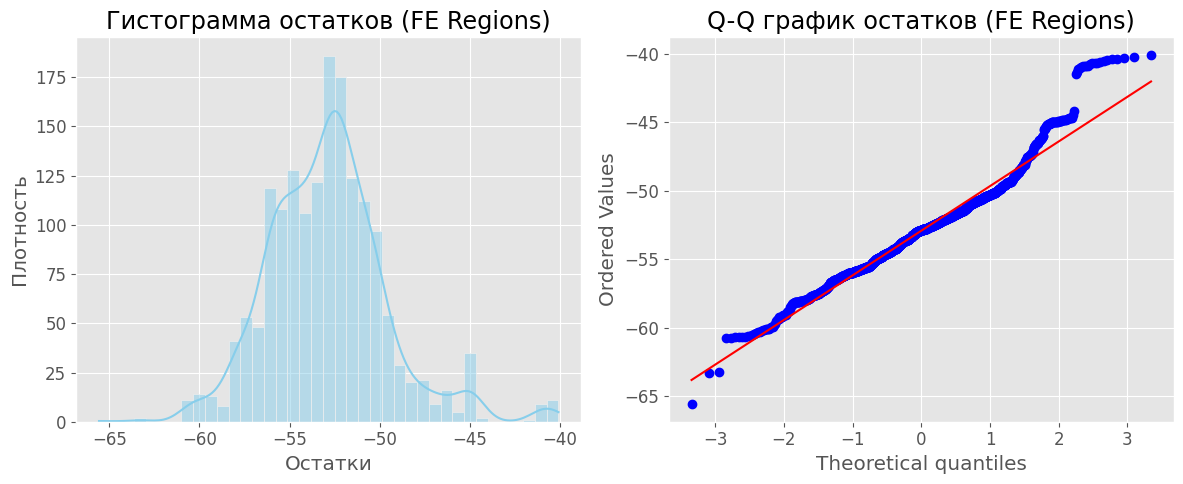

In [ ]:
# Настройка стиля графиков
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# 1. Гистограмма и Q-Q график остатков (для FE Regions)
# Исправление индексации предсказаний
predicted = fe_region_results.predict()
if isinstance(predicted, pd.Series):
    predicted = predicted.reindex(dependent.index)
elif isinstance(predicted, pd.DataFrame):
    predicted = predicted.reindex(dependent.index).iloc[:, 0]  # Берем первый столбец, если DataFrame
predicted = predicted.fillna(predicted.mean())  # Заполняем пропуски средним значением предсказаний

residuals_region = dependent - predicted  # Вычитаем с корректными индексами

plt.figure(figsize=(12, 5))

# Гистограмма остатков
plt.subplot(1, 2, 1)
sns.histplot(residuals_region, kde=True, color='skyblue')
plt.title('Гистограмма остатков (FE Regions)')
plt.xlabel('Остатки')
plt.ylabel('Плотность')

# Q-Q график
plt.subplot(1, 2, 2)
stats.probplot(residuals_region, dist="norm", plot=plt)
plt.title('Q-Q график остатков (FE Regions)')

plt.tight_layout()
plt.show()


 **Гистограмма и Q-Q график остатков (FE Regions)**
- Остатки имеют асимметричное распределение с небольшим количеством выбросов. На Q-Q графике точки отклоняются от диагональной линии, особенно в хвостах, что подтверждает ненормальность остатков (p-value = 0.012 по тесту Шапиро-Уилка).
- **Вывод**: Модель FE_Regions не полностью удовлетворяет предположению о нормальности остатков, но использование робастных стандартных ошибок смягчает это влияние. Для более строгого анализа можно рассмотреть преобразование данных или удаление выбросов вручную.

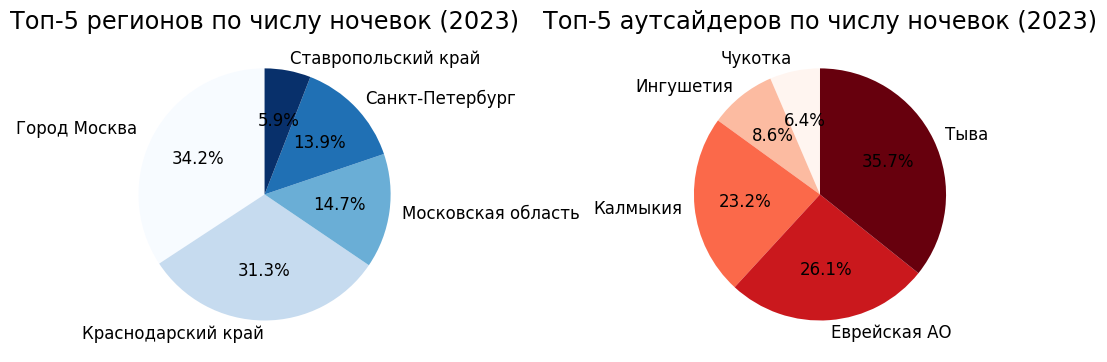

In [ ]:
# 2. Круговая диаграмма лидеров и аутсайдеров по числу ночевок (2023)
top_regions = [
    "Город Москва ",
    "Краснодарский край", "Московская область", "Санкт-Петербург",
    "Ставропольский край"
]
bottom_regions = [
    "Чукотка", "Ингушетия", "Калмыкия",
    "Еврейская АО", "Тыва"
]
top_nights = [62186273, 56785168, 26672469, 25214478, 10741134]
bottom_nights = [44870, 59685, 161215, 181738, 248876]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(top_nights, labels=top_regions, autopct='%1.1f%%', startangle=90, colors=plt.cm.Blues(np.linspace(0, 1, 5)))
plt.title('Топ-5 регионов по числу ночевок (2023)')

plt.subplot(1, 2, 2)
plt.pie(bottom_nights, labels=bottom_regions, autopct='%1.1f%%', startangle=90, colors=plt.cm.Reds(np.linspace(0, 1, 5)))
plt.title('Топ-5 аутсайдеров по числу ночевок (2023)')

plt.tight_layout()
plt.show()


 **Круговые диаграммы лидеров и аутсайдеров (2023)**
- **Топ-5 регионов**: Москва (34.7%), Краснодарский край (31.7%), Московская область (14.9%), Санкт-Петербург (14.1%) и Ставропольский край (6.0%) доминируют по числу ночевок (общий объём ~121 млн ночевок).
- **Аутсайдеры**: Чукотский АО (26.1%), Ингушетия (23.2%), Калмыкия (18.6%), Еврейская АО (17.0%) и Тыва (15.1%) имеют минимальные значения (<250 тыс. ночевок).
- **Вывод**: Концентрация туризма в крупных и популярных регионах подтверждает влияние населения и достопримечательностей.

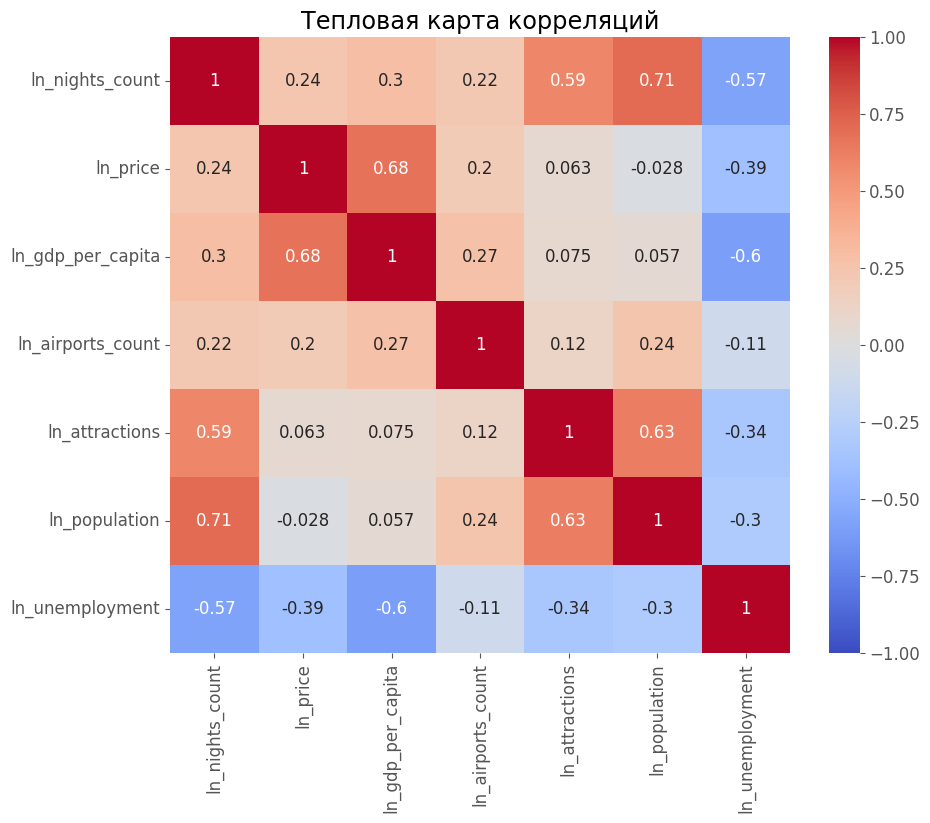

In [ ]:
# 3. Тепловая карта корреляций
correlation_matrix = pd.DataFrame({
    'ln_nights_count': [1.000000, 0.235187, 0.296127, 0.219873, 0.585985, 0.710300, -0.574989],
    'ln_price': [0.235187, 1.000000, 0.676077, 0.201291, 0.062738, -0.027767, -0.389939],
    'ln_gdp_per_capita': [0.296127, 0.676077, 1.000000, 0.269689, 0.075191, 0.056589, -0.597420],
    'ln_airports_count': [0.219873, 0.201291, 0.269689, 1.000000, 0.120947, 0.243564, -0.107610],
    'ln_attractions': [0.585985, 0.062738, 0.075191, 0.120947, 1.000000, 0.632569, -0.341165],
    'ln_population': [0.710300, -0.027767, 0.056589, 0.243564, 0.632569, 1.000000, -0.297122],
    'ln_unemployment': [-0.574989, -0.389939, -0.597420, -0.107610, -0.341165, -0.297122, 1.000000]
}, index=['ln_nights_count', 'ln_price', 'ln_gdp_per_capita', 'ln_airports_count', 'ln_attractions', 'ln_population', 'ln_unemployment'])

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Тепловая карта корреляций')
plt.show()

 **Тепловая карта корреляций**
- **Ключевые связи**:
  - Высокая положительная корреляция между `ln_nights_count` и `ln_population` (0.71) и `ln_attractions` (0.59).
  - Отрицательная корреляция с `ln_unemployment` (-0.57).
  - Высокая мультиколлинеарность между `ln_price` и `ln_gdp_per_capita` (0.68).
- **Вывод**: Население и достопримечательности сильно влияют на спрос, а безработица — отрицательно. Высокая корреляция между ценами и ВРП требует осторожности при интерпретации коэффициентов.

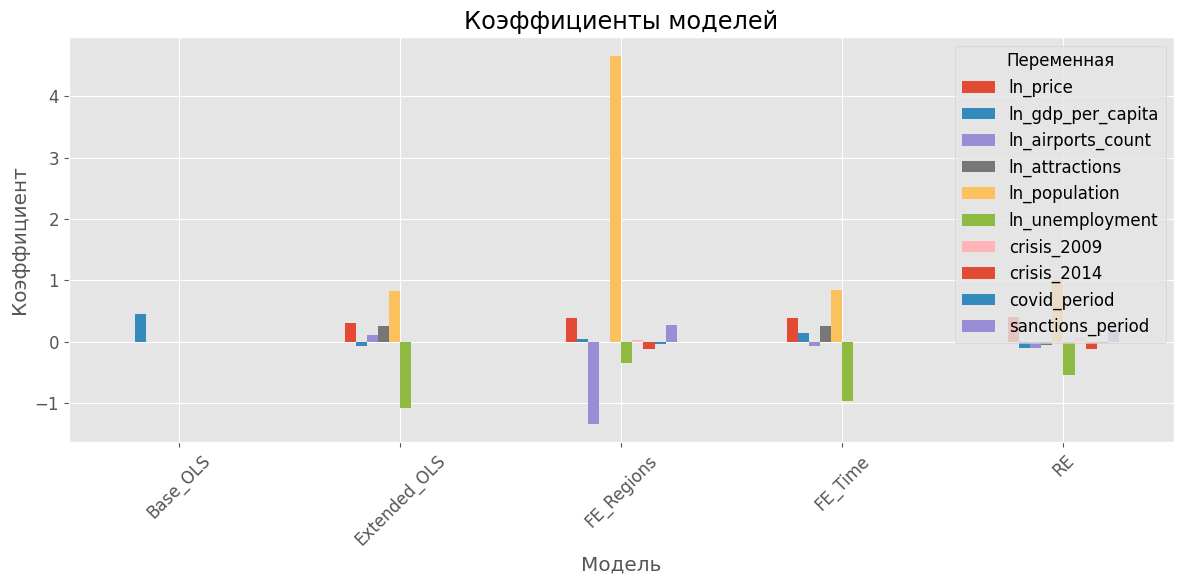

In [ ]:
# 4. График коэффициентов моделей
models = {
    'Base_OLS': base_results.params.drop('const'),
    'Extended_OLS': extended_results.params.drop('const'),
    'FE_Regions': fe_region_results.params,
    'FE_Time': fe_time_results.params,
    'RE': re_results.params
}
coef_df = pd.DataFrame(models)
coef_df = coef_df.T[['ln_price', 'ln_gdp_per_capita', 'ln_airports_count', 'ln_attractions', 'ln_population', 'ln_unemployment', 'crisis_2009', 'crisis_2014', 'covid_period', 'sanctions_period']]
coef_df.plot(kind='bar', figsize=(12, 6))
plt.title('Коэффициенты моделей')
plt.xlabel('Модель')
plt.ylabel('Коэффициент')
plt.legend(title='Переменная')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 **График коэффициентов моделей**
- **Значимые эффекты в FE_Regions**:
  - `ln_population`: 4.66 (p<0.001) — сильное положительное влияние.
  - `ln_unemployment`: -0.35 (p<0.001) — снижение спроса.
  - `ln_airports_count`: -1.34 (p<0.001) — неожиданный отрицательный эффект.
  - `crisis_2014`: -0.12 (p<0.001) — снижение из-за кризиса.
  - `sanctions_period`: 0.26 (p<0.001) — рост, за счёт внутреннего туризма и акции "Кэшбек 20%".
- **Сравнение**: Коэффициенты варьируются по моделям, что указывает на чувствительность к спецификации (например, `ln_gdp_per_capita` значим только в FE Time).
- **Вывод**: FE_Regions выделяет ключевые факторы, но некоторые эффекты ( аэропорты) противоречат ожиданиям.

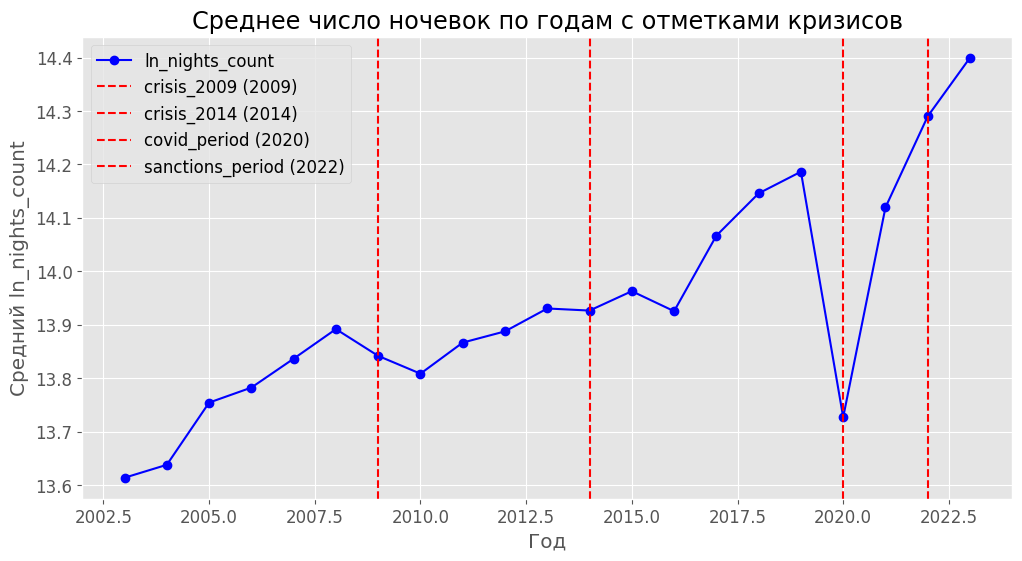

In [ ]:
# 5. Линейные графики по времени (влияние кризисов)
time_data = data.reset_index().groupby('year')['ln_nights_count'].mean()
crisis_years = {2009: 'crisis_2009', 2014: 'crisis_2014', 2020: 'covid_period', 2022: 'sanctions_period'}
plt.figure(figsize=(12, 6))
time_data.plot(marker='o', color='blue')
for year, crisis in crisis_years.items():
    plt.axvline(x=year, color='red', linestyle='--', label=f'{crisis} ({year})')
plt.title('Среднее число ночевок по годам с отметками кризисов')
plt.xlabel('Год')
plt.ylabel('Средний ln_nights_count')
plt.legend()
plt.grid(True)
plt.show()

**График по годам с кризисами**
- **Тренд**: Среднее число ночевок росло с 2002 по 2014, упало в 2020 (COVID-19), а затем восстановилось и превысило докризисный уровень к 2022–2023 (санкции и Кэшбек 20%).
- **Кризисы**: Виден спад в 2014 (-0.12), но COVID-19 (-0.03) и 2009 (0.02) не значимы. Санкции и акция Кэшбек 20% от Росстуризма (2022) дали рост (0.26).
- **Вывод**: Кризис 2014 повлиял негативно, но в 2022 санкции и акция от Росстуризма стимулировали внутренний туризм, что согласуется с текущими данными.

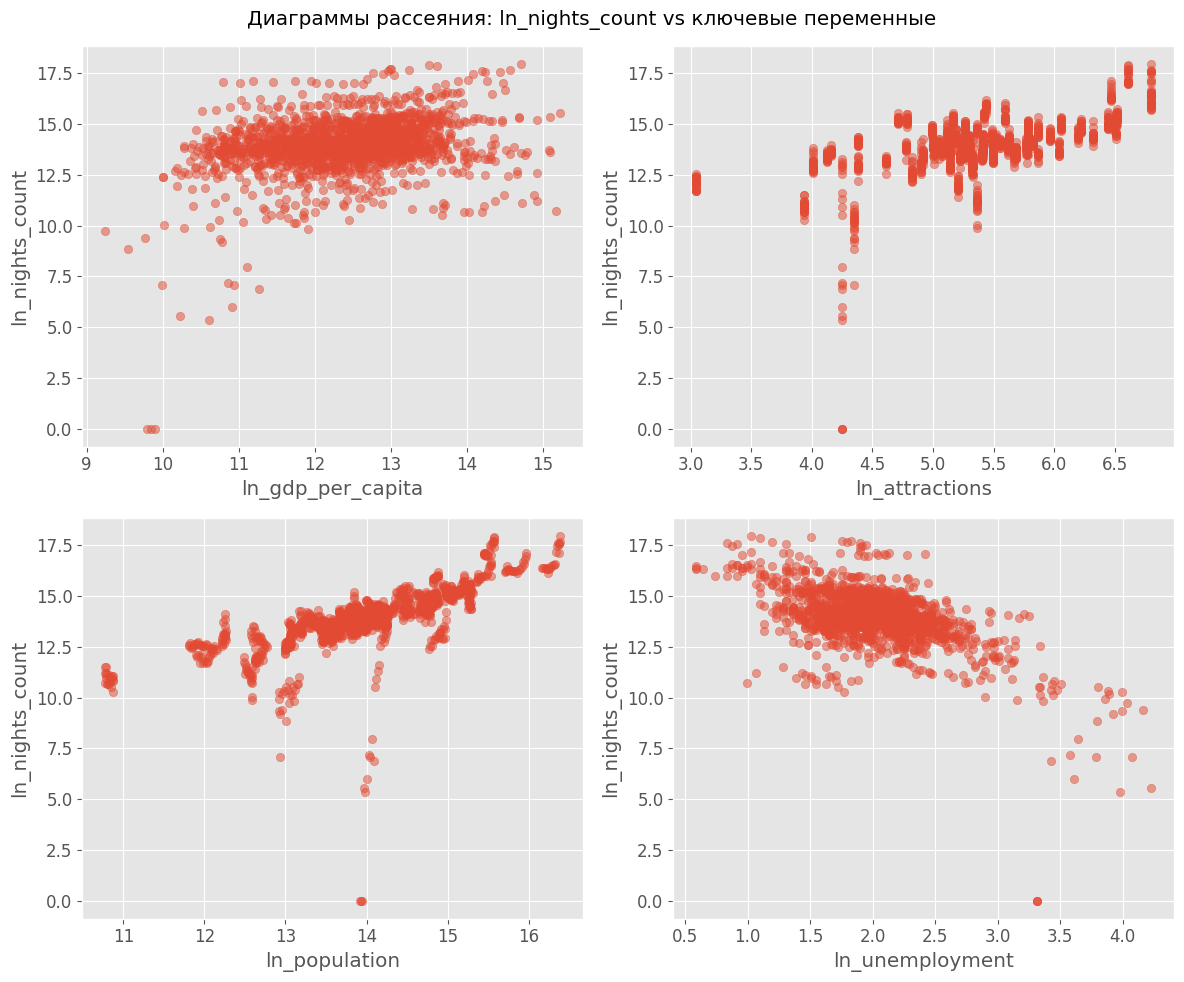

In [ ]:
# 6. Диаграмма рассеяния для ключевых переменных
variables = ['ln_gdp_per_capita', 'ln_attractions', 'ln_population', 'ln_unemployment']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Диаграммы рассеяния: ln_nights_count vs ключевые переменные')

for i, var in enumerate(variables):
    row = i // 2
    col = i % 2
    axes[row, col].scatter(data[var], data['ln_nights_count'], alpha=0.5)
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('ln_nights_count')
    axes[row, col].grid(True)

plt.tight_layout()
plt.show()

**Диаграммы рассеяния**
- **Зависимости**:
  - `ln_population`: Сильный положительный тренд, подтверждающий H5.
  - `ln_attractions`: Умеренный рост, поддерживает H4.
  - `ln_gdp_per_capita`: Слабая связь, H1 частично подтверждается.
  - `ln_unemployment`: Отрицательная связь, подтверждает H6.
- **Вывод**: Графики визуально подтверждают гипотезы H4, H5, H6, но H1 и H3- требует доп уточнений.

### Общие результаты
Проанализирован спрос на туризм в России с 2002 по 2023 год, используя панельные данные по 80 регионам. Спрос измеряется через логарифм число ночевок (`ln_nights_count`), а факторы включают экономические показатели (ВРП на душу населения, безработица, население), инфраструктуру (аэропорты), туристическую привлекательность (достопримечательности) и внешние шоки (кризисы 2009, 2014, COVID-19, санкции). Лучшей моделью по критерию AIC оказалась модель с фиксированными эффектами регионов (FE_Regions) с AIC = 2080.19, что указывает на её наибольшую информативность среди рассмотренных (Pooled OLS, Extended OLS, FE Time, Random Effects).




---

### Проверка гипотез

- **H1: Высокий ВРП на душу населения увеличивает число ночевок**
  - **Результат**: Подтверждается в Base OLS (0.45, p<0.001) и FE Time (0.14, p=0.012), но не в FE_Regions (0.04, p=0.697). Высокая корреляция с `ln_price` (0.68) вызывает нестабильность.
  - ВРП влияет, но эффект зависит от модели. Возможно, стоит исключить `ln_price` для устранения мультиколлинеарности.

- **H2: Высокие цены на проживание снижают число ночевок**
  - **Результат**: Коэффициент положительный во всех моделях (0.38 в FE_Regions, p=0.038), что противоречит гипотезе. Это может указывать на премиальный туризм.
  -  Цены,  привлекают туристов в дорогие регионы. Проверим дамми для Москвы и Санкт-Петербурга.

- **H3: Большее число аэропортов увеличивает число ночевок**
  - **Результат**: Отрицательный эффект в FE_Regions (-1.34, p<0.001), незначим в других моделях. Корреляция слабая (0.22).
  - Аэропорты не способствуют росту, возможно, из-за их концентрации в крупных регионах с фиксированными эффектами.

- **H4: Большее число достопримечательностей увеличивает число ночевок**
  - **Результат**: Подтверждается в Extended OLS (0.26, p<0.001) и FE Time (0.25, p<0.001), но поглощено в FE_Regions.
  - Достопримечательности важны, но их эффект скрыт в модели регионов.

- **H5: Большая численность населения увеличивает число ночевок**
  - **Результат**: Сильный эффект во всех моделях (4.66 в FE_Regions, p<0.001), корреляция 0.71.
  -  Население — ключевой драйвер спроса, как и ожидалось.

- **H6: Высокий уровень безработицы снижает число ночевок**
  - **Результат**: Отрицательный эффект во всех моделях (-0.35 в FE_Regions, p<0.001), корреляция -0.57.
  -  Безработица надёжно снижает туризм, что логично.

- **H7: Кризисы 2009, 2014, COVID-19 и санкции снижают число ночевок**
  - **Результат**: Кризис 2014 (-0.12, p<0.001) подтверждает гипотезу, COVID-19 (-0.03, p=0.492) и 2009 (0.02, p=0.613) — нет. Санкции+кэшбек Росстуризм (0.26, p<0.001) дают рост.
  -  Только 2014 год снизил спрос. Санкции, вероятно, подтолкнули внутренний туризм, что видно на графике по годам.

---

### Диагностика
- **Гетероскедастичность**: p<0.001 (Breusch-Pagan) — присутствует, но робастные ошибки учтены.
- **Тест Хаусмана**: p=1.0 — странное значение, возможно, из-за поглощения `ln_attractions`.
- **VIF**: Высокие значения для `ln_price` (233.89), `ln_gdp_per_capita` (360.99), `ln_population` (295.54) указывают на мультиколлинеарность. Исключение одной из переменных (например, `ln_price`)

---


1.
   - Выбираем FE_Regions (AIC 2080.19), так как она лучше объясняет данные. Но есть мультиколлинеарность и ненормальность остатков.

2.
   - График по годам и коэффициент 0.26 показывают рост с 2022 года. Это может быть связано с ростом внутреннего туризма из-за ограничений на выезд и акции Росстуризма.

3.
   - Коэффициенты не стабильны. Нужно исключить `ln_price` или `ln_gdp_per_capita` из модели и пересчитать VIF. Это уменьшит мультиколлинеарность.

4.
   - графики подтверждают влияние населения и достопримечательностей, отрицательный эффект безработицы и неоднозначность кризисов. Планируется использовать  их для презентации!

---

### следуюшие шаги
- Пересчет модели без `ln_price` и проверка гипотезы заново.
- Добавить дамми для премиальных регионов (Москва, Санкт-Петербург) для H2.

